# Deep Learning:Final Project

In [ ]:
import tensorflow_datasets as tfds

import tensorflow as tf
import tensorflow.io as tfio
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip,RandomRotation, RandomTranslation
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
!pip install patchify
from patchify import patchify, unpatchify


***
### Step 1 - Load Dataset

The EuroSat database is loaded from the tensorflow dataset

***

In [ ]:
#Extract the EuroSAT dataset
(train_data, train_labels), (test_data, test_labels) = tfds.as_numpy(tfds.load('eurosat', 
                                                                               split=['train[:80%]','train[:80%]'], 
                                                                               batch_size= -1, 
                                                                               shuffle_files = True, 
                                                                               as_supervised = True))

LABELS = [
          'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 
          'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteBHIBGS/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


***
### Data Augmentation

***

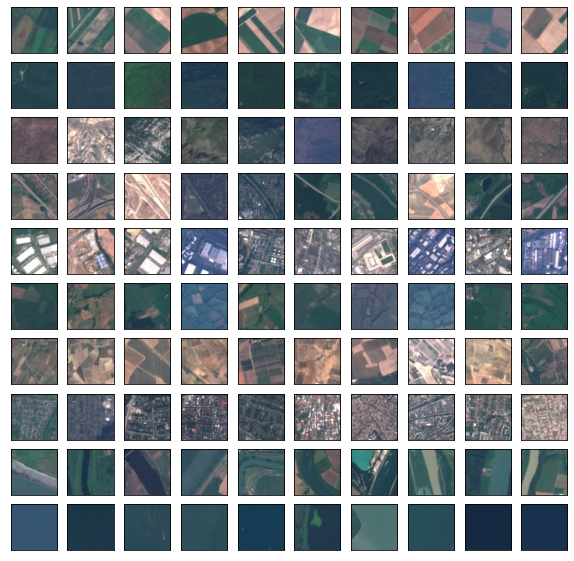

In [ ]:
data_augmentation = Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2)])
augmented_data = data_augmentation(train_data)

***
### Step 2 - My own model

The model consists of the following layers:

*   Convolution layer of size 64
*   2X2 MaxPooling 
*   Dropout layer to reduce overfitting
*   Convolution layer of size 128
*   2X2 MaxPooling 
*   Dropout layer to reduce overfitting
*   Convolution layer of size 256
*   2X2 MaxPooling 
*   Dropout layer to reduce overfitting
*   Convolution layer of size 512
*   2X2 MaxPooling 
*   Dropout layer to reduce overfitting
*   Flatten layer for the top
*   Dense layer consisting of 1000 neurons
*   Output layer of 10 neurons for the 10 outputs

***


In [ ]:
inputs = tf.keras.Input(shape=(64,64,3), name='input')
x = Conv2D(64,3, padding='same', name='First_Layer',activation="relu")(inputs)
x = MaxPooling2D((2,2), name='2x2_MaxPool1')(x)
x = Dropout(rate=0.2)(x)
x = Conv2D(128,3, padding='same', name='Second_Layer',activation="relu")(x)
x = MaxPooling2D((2,2), name='2x2_MaxPool2')(x)
x = Dropout(rate=0.2)(x)
x = Conv2D(256,3, padding='same', name='Third_Layer',activation="relu")(x)
x = MaxPooling2D((2,2), name='2x2_MaxPool3')(x)
x = Dropout(rate=0.2)(x)
x = Conv2D(512,3, padding='same', name='Fourth_Layer',activation="relu")(x)
x = MaxPooling2D((2,2), name='2x2_MaxPool4')(x)
x = Dropout(rate=0.2)(x)
x = Flatten()(x)
x = Dense(1000,activation='relu')(x)
outputs = Dense(10, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs,name = "My_Model")
model.summary()


Model: "My_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 64, 64, 3)]       0         
_________________________________________________________________
First_Layer (Conv2D)         (None, 64, 64, 64)        1792      
_________________________________________________________________
2x2_MaxPool1 (MaxPooling2D)  (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
Second_Layer (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
2x2_MaxPool2 (MaxPooling2D)  (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0  

Train Loss:  0.15243719518184662
Test Loss:  0.7265862822532654
Train Accuracy:  0.9473147988319397
Test Accuracy:  0.8290740847587585


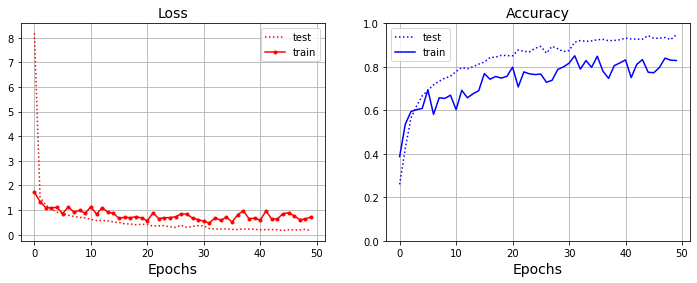

In [ ]:
model.compile(optimizer= 'adam', loss='sparse_categorical_crossentropy'
             ,metrics=['accuracy'])
history = model.fit(augmented_data, train_labels, epochs=50, batch_size=128
                   , verbose=0, validation_data=(test_data, test_labels))

# Plotting of the results of my model
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],':r')
plt.plot(history.history['val_loss'],'.-r')
plt.title('Loss',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend({'train','test'})
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],':b')
plt.plot(history.history['val_accuracy'],'b')
plt.ylim([0, 1])
plt.title('Accuracy',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend({'train','test'})
plt.grid()


print("Train Loss: " , history.history['loss'][-1])
print("Test Loss: ", history.history['val_loss'][-1])

print("Train Accuracy: " , history.history['accuracy'][-1])
print("Test Accuracy: ", history.history['val_accuracy'][-1])

***
### Step 3 - a. Pretrained model

A pretrained model of VGG-19. The top is not added as we need our own (VGG-19 top is built specifically for the imagenet contest)

The top we add manually consists of a Dense layer of 1000 neurons and an output layer of 10 neurons.
***

In [ ]:
vgg19 = tf.keras.applications.VGG19(input_shape=(64,64,3),include_top=False, weights='imagenet')
vgg19.trainable = False

vgg19_model = Sequential()
vgg19_model.add(vgg19)
vgg19_model.add(Flatten())
vgg19_model.add(Dense(1000,activation='relu'))
vgg19_model.add(Dense(10, activation='softmax'))
vgg19_model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              2049000   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                10010     
Total params: 22,083,394
Trainable params: 2,059,010
Non-trainable params: 20,024,384
_________________________________________________________________


***
###Step 3 - b.Transfer Learning

As a first step, the top is trained, as the model contains pretrained wheights that are good so messing them up is not a good idea
***

In [ ]:
vgg19_model.compile(optimizer= 'adam', loss='sparse_categorical_crossentropy'
             ,metrics=['accuracy'])
vgg19_history = vgg19_model.fit(augmented_data, train_labels, epochs=30, batch_size=128
                   , verbose=0, validation_data=(test_data, test_labels))


***
### Step 3 - c. Fine-tuning

After the top is trained, the pretrained wheights are fine-tuned by training them with a very slow learning rate, so they match better to the given dataset.
***

Train Loss:  7.204348366940394e-05
Test Loss:  1.2133578062057495
Train Accuracy:  1.0
Test Accuracy:  0.901805579662323


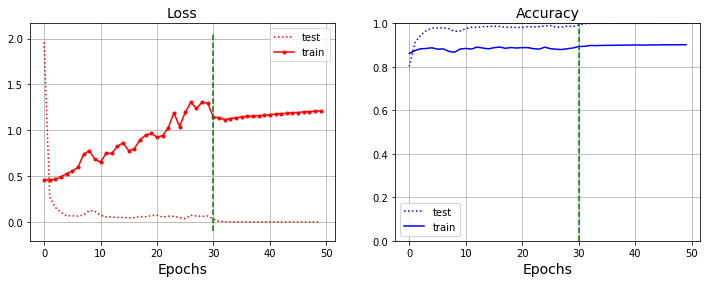

In [ ]:

vgg19_model.layers[0].trainable = True

my_opt = keras.optimizers.Adam(learning_rate=0.000001)

vgg19_model.compile(optimizer= my_opt, loss='sparse_categorical_crossentropy'
             ,metrics=['accuracy'])

vgg19_history2 = vgg19_model.fit(augmented_data, train_labels, epochs=20, batch_size=128
                   , verbose=0, validation_data=(test_data, test_labels))


loss = vgg19_history.history['loss'] + vgg19_history2.history['loss']
accuracy = vgg19_history.history['accuracy'] + vgg19_history2.history['accuracy']
val_loss = vgg19_history.history['val_loss'] + vgg19_history2.history['val_loss']
val_accuracy = vgg19_history.history['val_accuracy'] + vgg19_history2.history['val_accuracy']

# Plotting the results of the VGG-19 model after the transfer learning and fine-tuning
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(loss,':r')
plt.plot(val_loss,'.-r')
plt.plot([30,30], plt.ylim(),'--g')
plt.title('Loss',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend({'train','test'})
plt.grid()

plt.subplot(1,2,2)
plt.plot(accuracy,':b')
plt.plot(val_accuracy,'b')
plt.ylim([0, 1])
plt.plot([30,30], plt.ylim(),'--g')
plt.title('Accuracy',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend({'train','test'})
plt.grid()

print("Train Loss: " , loss[-1])
print("Test Loss: ", val_loss[-1])

print("Train Accuracy: " , accuracy[-1])
print("Test Accuracy: ", val_accuracy[-1])


***
###Summary

<table>
  <tr>
    <th>Model</th>
    <th># of parameters</th>
    <th>train loss</th>
    <th>test loss</th>
    <th>train accuracy</th>
    <th>test accuracy</th>
    <th>batch size</th>
  </tr>
  <tr> 
    <td>My Model</td>   
    <td>9,753,986</td>
    <td> 0.15</td> 
    <td> 0.72</td> 
    <td> 0.94</td>
    <td> 0.82</td>
    <td> 128</td>
  </tr>
  <tr> 
    <td>VGG-19</td>   <!-- Model -->
    <td>22,083,394</td> <!-- #parameters -->
    <td> 7.20e-05</td> <!-- train accuracy -->
    <td> 1.21</td> <!-- test accuracy -->
    <td> 1.0</td>
    <td> 0.90</td>
    <td> 128</td>
  </tr>
</table>

From the summary, it seems that the VGG-19 model return better results, so we will use it to classify the image of Cesarea
***

***
###Confusion Matrix
***

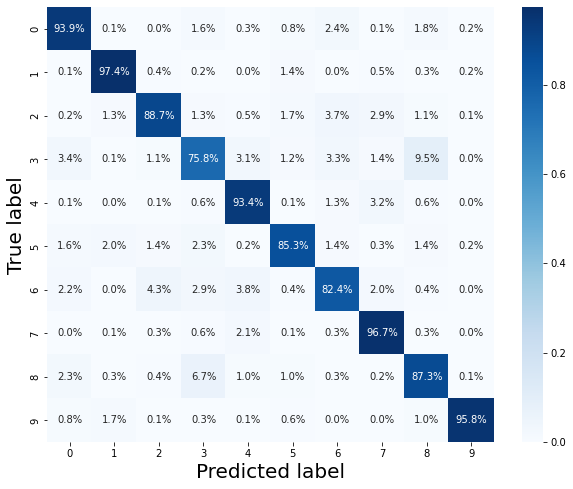

In [ ]:
y_hat = vgg19_model.predict(test_data)
y_hat = np.argmax(y_hat, axis=1)
CM = confusion_matrix(test_labels, y_hat)
CM = CM / CM.sum(axis=1)

plt.figure(figsize=(10,8))
heatmap(CM,cmap='Blues',annot=True, fmt='.1%')
plt.xlabel('Predicted label', fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.show()

***
### TNSE 

Plotting the one before last layer of the model using TNSE, as it provides better results than PCA
***

In [ ]:
features_extractor = keras.Model(inputs=vgg19_model.inputs, outputs=vgg19_model.layers[-2].output)

features = features_extractor.predict(test_data)
features.shape


(21600, 1000)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=50).fit(features)

features_2D = pca.transform(features)
features_2D.shape

features_2D = TSNE(n_components=2).fit_transform(features_2D)
features_2D.shape

(21600, 2)

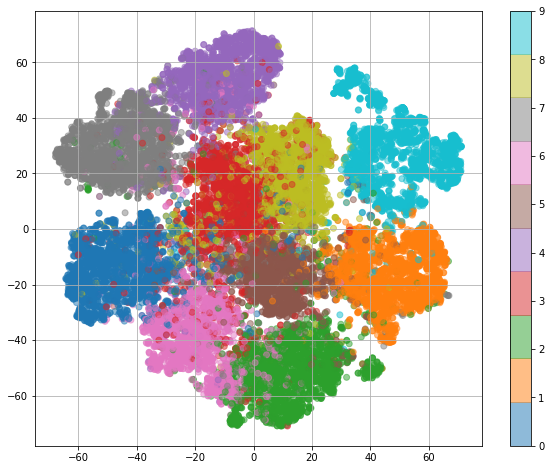

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(features_2D[:,0], features_2D[:,1], c=test_labels, cmap='tab10', alpha=0.5)
plt.colorbar()
plt.grid()
plt.show()

***
### Classification of Cesarea image
***

In [ ]:
img = plt.imread('Cesarea.tiff')

# Dividing the image to patches with a stride of 8
patches = patchify(img, (64,64,3), step= 8) 
reshaped_patches = np.reshape(patches,(patches.shape[0]*patches.shape[1]*patches.shape[2],64,64,3))

#Predicting the classifications of the patches
result = vgg19_model.predict(reshaped_patches)

(6561, 10)


In [ ]:
import cv2

#Painting each patch with a color, corresponding to the classification result
results = np.argmax(result, axis=1)
for c in range(patches.shape[0]):
    for i in range(patches.shape[0]):
        if results[c*patches.shape[0]+i] == 0:
              cv2.rectangle(reshaped_patches[c*patches.shape[0]+i], (0,0), (64,64), (232,73,25), -1)
        elif results[c*patches.shape[0]+i] == 1:
              cv2.rectangle(reshaped_patches[c*patches.shape[0]+i], (0,0), (64,64), (63,174,36), -1)
        elif results[c*patches.shape[0]+i] == 2:
              cv2.rectangle(reshaped_patches[c*patches.shape[0]+i], (0,0), (64,64), (247,187,15), -1)
        elif results[c*patches.shape[0]+i] == 3:
              cv2.rectangle(reshaped_patches[c*patches.shape[0]+i], (0,0), (64,64), (30,149,191), -1)
        elif results[c*patches.shape[0]+i] == 4:
              cv2.rectangle(reshaped_patches[c*patches.shape[0]+i], (0,0), (64,64), (193,40,153), -1)
        elif results[c*patches.shape[0]+i] == 5:
              cv2.rectangle(reshaped_patches[c*patches.shape[0]+i], (0,0), (64,64), (24,219,203), -1)
        elif results[c*patches.shape[0]+i] == 6:
              cv2.rectangle(reshaped_patches[c*patches.shape[0]+i], (0,0), (64,64), (142,142,142), -1)
        elif results[c*patches.shape[0]+i] == 7:
              cv2.rectangle(reshaped_patches[c*patches.shape[0]+i], (0,0), (64,64), (53,53,53), -1)
        elif results[c*patches.shape[0]+i] == 8:
              cv2.rectangle(reshaped_patches[c*patches.shape[0]+i], (0,0), (64,64), (25,232,73), -1)
        elif results[c*patches.shape[0]+i] == 9:
              cv2.rectangle(reshaped_patches[c*patches.shape[0]+i], (0,0), (64,64), (73,25,232), -1)

***
### Plotting the classification map

After painting the patches, they are repatchified back to the original image, but this time the image consists of the colors according to their classifications.
***

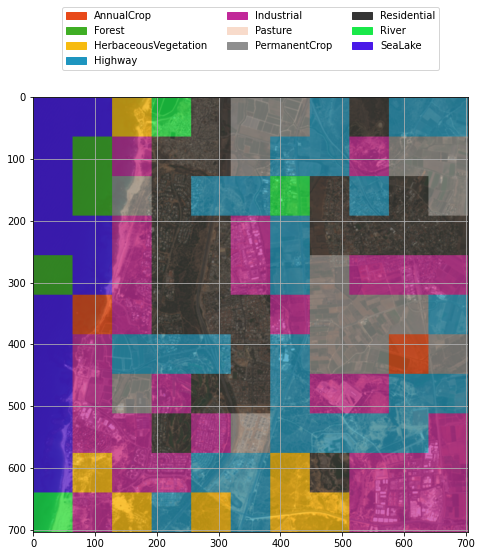

In [ ]:
import matplotlib.patches as mpatches

classification_patches = np.reshape(reshaped_patches,patches.shape)
classification_img = unpatchify(classification_patches, img.shape)

# Creating the legend of the classifications
AnnualCrop = mpatches.Patch(color=(232/255.0,73/255.0,25/255.0), label=LABELS[0])
Forest = mpatches.Patch(color=(63/255.0,174/255.0,36/255.0), label=LABELS[1])
HerbaceousVegetation = mpatches.Patch(color=(247/255.0,187/255.0,15/255.0), label=LABELS[2])
Highway = mpatches.Patch(color=(30/255.0,149/255.0,191/255.0), label=LABELS[3])
Industrial = mpatches.Patch(color=(193/255.0,40/255.0,153/255.0), label=LABELS[4])
Pasture = mpatches.Patch(color=(248/255.0,219/255.0,203/255.0), label=LABELS[5])
PermanentCrop =  mpatches.Patch(color=(142/255.0,142/255.0,142/255.0), label=LABELS[6])
Residential = mpatches.Patch(color=(53/255.0,53/255.0,53/255.0), label=LABELS[7])
River = mpatches.Patch(color=(25/255.0,232/255.0,73/255.0), label=LABELS[8])
SeaLake = mpatches.Patch(color=(73/255.0,25/255.0,232/255.0), label=LABELS[9])

handleList = [AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, SeaLake]

#Plotting the results on top of the original image
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.imshow(classification_img,alpha= 0.7)
plt.legend(handles=handleList, loc='lower center', bbox_to_anchor=(0.5, 1.05),ncol=3)
plt.grid()

***
### Heatmap of the highway classification
Plotting a heatmap of a single classification and sowing the result on top of the original image
***

(704, 704)


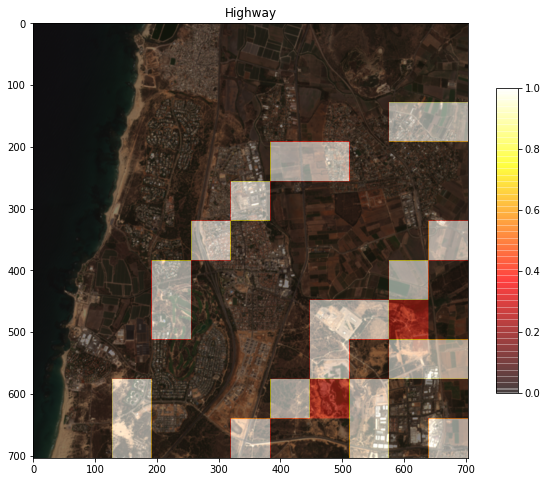

In [ ]:
heatmap = np.zeros((img.shape[0],img.shape[1]))
for c in range(patches.shape[0]):
    for i in range(patches.shape[0]):
      heatmap[int(c*64) : int(c*64+64), int(i*64) : int(i*64+64)] = result[c*i][3]
plt.figure(figsize=(10,8))
plt.title(LABELS[3])
plt.imshow(img)
plt.imshow(heatmap, cmap = 'hot', alpha= 0.5)
plt.colorbar(shrink=0.7, aspect=20*0.7)